   CodiceColore  PianoTaglia  AreaCode  CategoryCode  SectorCode  \
0      -0.86386    -2.196063 -1.057982     -1.002886   -0.978144   

   DepartmentCode  WaveCode  AstronomicalSeasonExternalID  \
0       -1.003347 -1.297348                     -1.424692   

   SalesSeasonDescription  LocationId  
0               -1.354523   -1.742905  
231_969_78976_03_10E_1.jpg
22



231_969_78976_03_10E_2.jpg
[-0.86386028 -2.1960633  -1.05798172 -1.00288557 -0.97814353 -1.00334732
 -1.29734821 -1.42469226 -1.35452325 -1.74290516]
22


c:\Users\GRVRLD00P\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(
C:\Users\GRVRLD00P\AppData\Local\Temp\ipykernel_2368\2786225199.py:31: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3701.)
  plt.imshow(np.squeeze(image.T))


ValueError: not enough values to unpack (expected 4, got 3)

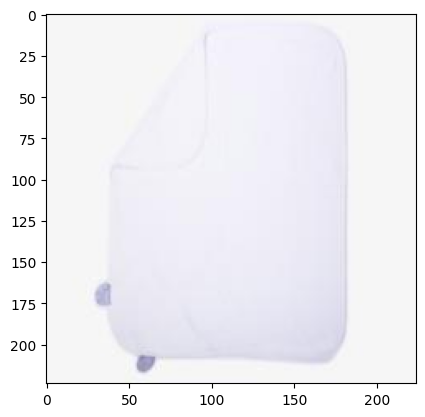

In [2]:
from sales_prediction.preproc_tabular import get_tabular
import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import v2
from torchvision.io import ImageReadMode

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406) #presi da timm
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

class SalesDataset(Dataset):
    def __init__(self, references, tabular_data, img_path, target, transform=None, target_transform=None):
        self.img_ref = references 
        self.tabular = tabular_data
        self.target = target
        self.img_path = img_path
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_ref)
    
    def __getitem__(self, idx):
        image = read_image(self.img_path + self.img_ref[idx], ImageReadMode.RGB)
        print(self.img_ref[idx])
        plt.imshow(np.squeeze(image.T))
        print(self.tabular.iloc[idx].values)
        print(self.target[idx])
        tabular_row = torch.from_numpy(self.tabular.iloc[idx].values).float()
        
        target = self.target[idx]
        
        if self.transform: 
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        
        return image, tabular_row, target 

def getDataset(references, tabular_data, target, img_path, batch_size, proportion):
    transform_img = v2.Compose([
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
    ])
    
    dataset = SalesDataset(references, tabular_data, img_path, target, transform_img, None)
    
    partial, _ = random_split(dataset, [proportion, 1 - proportion])
    
    splitted_dataset = random_split(partial, [0.7, 0.3])
    train_dataloader = DataLoader(splitted_dataset[0], batch_size=batch_size)
    validation_dataloader = DataLoader(splitted_dataset[1], batch_size=batch_size)

    return train_dataloader, validation_dataloader

img_path = 'C:\\Users\\GRVRLD00P\\Documents\\Progetto ORS\\Dati\\ResizedImages\\'
tab_path = 'C:\\Users\\GRVRLD00P\\Documents\\Progetto ORS\\Dati\\sales_anagrafica_final.csv'
aggregated_path = 'C:\\Users\\GRVRLD00P\\Documents\\Progetto ORS\\Dati\\aggregated_sales_season.csv'
aggregated_month_path = 'C:\\Users\\GRVRLD00P\\Documents\\Progetto ORS\\Dati\\aggregated_sales_month.csv'


data, ref, desc, target = get_tabular(aggregated_path)
print(data.head(1))
print(ref[0])
print(target[0])
print('\n\n')
train, val = getDataset(ref[0:2], data.head(2), target[0:2], img_path, 1, 0.000001)
for img, tab, tar in train:
    break


